# Import libraries

In [1]:
from semseg_functions import train_model, make_predictions
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

c:\Users\JOKER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

X_train,X_val,Y_train,Y_val=train_test_split(
  images,labels,
  test_size=0.2,
  stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),
  random_state=42
  )

X_train,X_val,Y_train,Y_val=(
  torch.FloatTensor(X_train).permute((0,3,1,2)),
  torch.FloatTensor(X_val).permute((0,3,1,2)),
  torch.LongTensor(Y_train),
  torch.LongTensor(Y_val)
  )

# Define Calculation

In [3]:
def dice_score(preds, targets, num_classes=3):
    scores = []
    preds = torch.argmax(torch.tensor(preds), dim=1).numpy()
    for cls in range(num_classes):
        pred_cls = (preds == cls).astype(int)
        true_cls = (targets.numpy() == cls).astype(int)
        intersection = (pred_cls * true_cls).sum()
        union = pred_cls.sum() + true_cls.sum()
        score = (2. * intersection) / (union + 1e-6)
        scores.append(score)
    return scores

# Train and Predict

In [4]:

model_key = "seunettrans" 
# Training with mit_b3 encoder will take a very long time and perform not as well as others, so we can skip it if needed.
encoders = ["resnet18", "resnet34", "resnet50", "resnet101", "resnext50_32x4d", "seresnet50", "densenet121", "mobilenet_v2", "efficientnet-b3"] # "mit_b3"
results = []

for encoder in encoders:
    model, training_loss, validation_loss = train_model(X_train, Y_train, X_val, Y_val, model_key=model_key, encoder_name=encoder, n_epochs=50)
    preds = make_predictions(X_val, model=model, model_key=model_key, encoder_name=encoder)
    
    dice = dice_score(preds, Y_val)

    results.append({
        "Encoder": encoder,
        "Dice_0": dice[0], "Dice_1": dice[1], "Dice_2": dice[2],
    })

model= seunettrans. Using Combo Loss and Lower Learning Rate
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 0, Loss: 3.093
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 1, Loss: 2.947
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 2, Loss: 3.273
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 3, Loss: 2.804
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 4, Loss: 2.62
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 5, Loss: 2.49
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 6, Loss: 2.608
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 7, Loss: 2.45
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 8, Loss: 2.389
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 9, Loss: 2.221
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 10, Loss: 2.171
Model: seunettrans, Encoder: resnet18. Training: Epoch 1, Batch 11, Loss

KeyboardInterrupt: 

# Table for Encoders Comparison

In [ ]:
results_df = pd.DataFrame(results)
results_df.set_index("Encoder", inplace=True)
display(results_df)

,Dice_0,Dice_1,Dice_2
Encoder,,,
resnet18,0.958552,0.878101,0.827524
resnet34,0.958529,0.889355,0.849262
resnet50,0.960551,0.887580,0.834618
resnet101,0.952545,0.874715,0.813469
resnext50_32x4d,0.956788,0.876323,0.825598
seresnet50,0.962706,0.891193,0.846394
densenet121,0.963450,0.891841,0.848692
mobilenet_v2,0.958357,0.854775,0.796424
efficientnet-b3,0.942524,0.845803,0.797176


# Bar Plots for Encoders Comparison

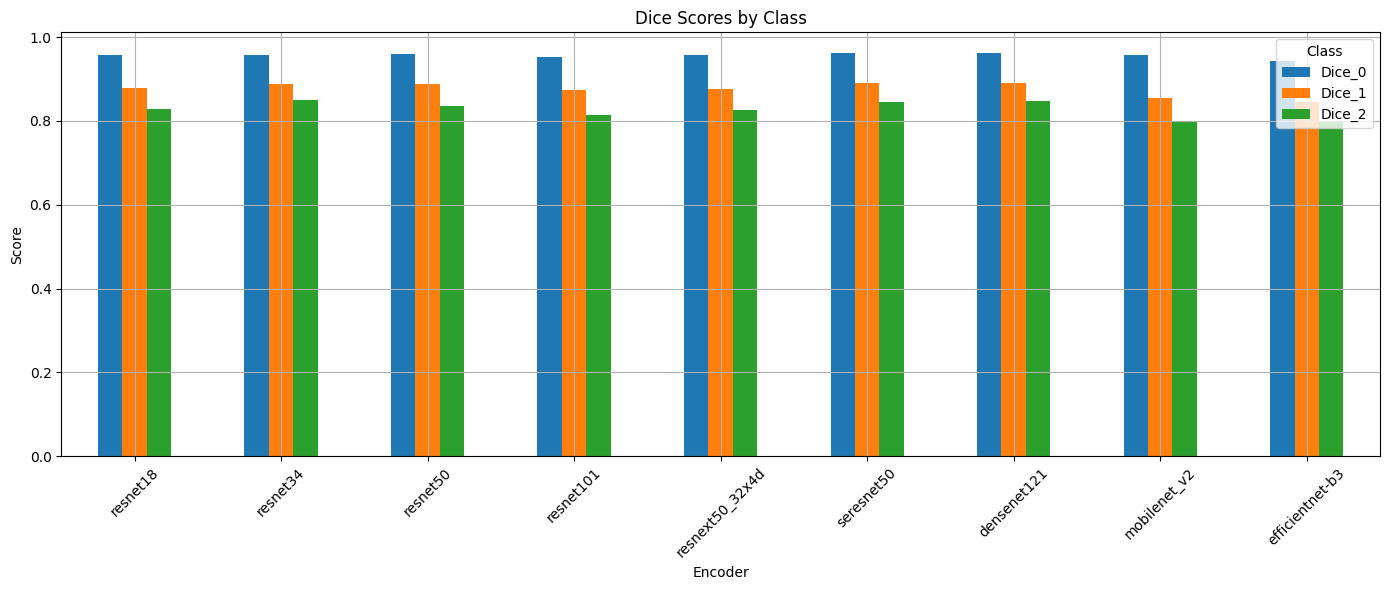

In [ ]:
dice_cols = ['Dice_0', 'Dice_1', 'Dice_2']
results_df[dice_cols].plot(kind='bar', figsize=(14, 6))
plt.title("Dice Scores by Class")
plt.ylabel("Score")
plt.xlabel("Encoder")
plt.xticks(rotation=45)
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()